In [31]:
import numpy as np 
import librosa
from typing import Tuple, Union, Callable
import pyaudio
import pickle

def load_audio_file(filespath):
    """
    Load an audio file and return the audio samples and sample rate.

    Args:
        filepath (str): Path to the audio file.

    Returns:
        Tuple[np.ndarray, int]: A tuple containing the audio samples as a NumPy array
        and the sample rate of the audio file.
    """
    #this depends on whether we have pre-recorded audio or not, otherwise this would change
    samples, sample_rate = librosa.load(filespath, sr=None) 
    print("done")
    return samples, sample_rate

In [33]:
from numba import njit
from scipy.ndimage import generate_binary_structure, iterate_structure
from matplotlib import mlab, pyplot as plt

# need to figure out best values for n_neighbors and cutoff_percentage
n_neighbors = 2
cutoff_percentage = 0.6

def spectro(samples):
    #N = len(samples)
    sampling_rate = 44100
    #times = np.arange(N) * (1/sampling_rate)
    #ck = np.fft.rfft(samples)
   #k = np.arange(N//2 + 1)
   # amps = np.abs(ck)/N
    #amps[1:-1] *= 2
    #ak = amps
    #fk = k * sampling_rate/N

    fig, ax = plt.subplots()
    S, freqs, times2, im = ax.specgram(
    samples,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
    )
    print("done")
    return S
    
def calculate_amp_min(S, cutoff_percentage):
    S = S.ravel()  
    ind = round(len(S) * cutoff_percentage)  
    amp_min = np.partition(S, ind)[ind] 
    return amp_min
    print("done")

@njit  
def _peaks(data_2d, neighborhood_row_offsets, neighborhood_col_offsets, amp_min):
    peaks = []
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            continue
        for dr, dc in zip(neighborhood_row_offsets, neighborhood_col_offsets):
            if dr == 0 and dc == 0:
                continue
            if not (0 <= r + dr < data_2d.shape[0]):
                continue
            if not (0 <= c + dc < data_2d.shape[1]):
                continue
            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                break
        else:
            peaks.append((r, c))
    print("done")
    return peaks

def local_peak_locations(data_2d, amp_min):
    base_structure = generate_binary_structure(2,1)
    neighborhood = iterate_structure(base_structure, n_neighbors)
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    neighborhood_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    neighborhood_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2
    return _peaks(data_2d, neighborhood_row_offsets, neighborhood_col_offsets, amp_min=amp_min)
    print("done")

def return_peaks(samples):
    S = spectro(samples)
    amp_min = calculate_amp_min(S, cutoff_percentage)
    peaks = local_peak_locations(S, amp_min)
    print("done")
    return peaks

In [53]:
#make fingerprints for each peak in a list of peaks
def make_fingerprints(peaks, n_neighbors):
    #sort peaks by frequency and time
    peaks = sorted(peaks, key=lambda x: (x[0], x[1]))

    fingerprints = []

    for i, current_peak in enumerate(peaks): #for index i and current peak
        f1, t1 = current_peak
        count = 0 #0 neighbors found so far
        fanout = []

        #go through peaks after to find neighbors
        for peak in peaks[i + 1:]:
            f2, t2 = peak
            delta_t = t2 - t1

            if delta_t >= 0: #the neighbor happens after the peak
                fanout.append(((f1, f2, delta_t), t1)) #add the neighbor to fanout
                count += 1

            if count >= n_neighbors: #once all neighbors are found
                break
        
        fingerprints.append(fanout) #add fanout to fingerprints
    print("done")
    return fingerprints

In [55]:
from database.models import Song
from database.repository import save_songs_to_file, load_songs_from_file

# Create some Song objects
song1 = Song("Saturn", "SZA", "SOS Deluxe: LANA", 2024, "studio_saturn.wav")
song2 = Song("You've Got a Friend in Me", "Randy Newman", "Toy Story", 1995, "studio_youvegotafriendinme.wav")
song3 = Song("Ruthless", "The Marias", "Superclean, Vol. II", 2018, "studio_ruthless.wav")

# Create a dictionary to store the songs
# Unique ID format = artist_songName
my_songs = {
    "sza_saturn": song1,
    "randynewman_youvegotafriendinme": song2,
    "themarias_ruthless": song3
}

In [75]:
import os
class AudioDatabase:
    ##initializes database based on path
    def _init_(self, db_path = "database.pkl"): ##what would this path be?
        self.db_path = db_path
        self.database = {}
        self.load_database()
    
    ##should check if database exists and loads it with pickel
    def load_database(self):
        if os.path.exists(self.db_path):
            with open(self.db_path, "rb") as f:
                self.database = pickle.load(f)
            print(f"Database loaded from {self.db_path}")
        else: 
            print(f"No database found at {self.db_path}")
    
    ##creates database, 
    def save_database(self):
        os.makedirs(os.path.dirname(self.db_path), exist_ok = True)
        with open(self.db_path, "wb") as f:
            pickle.dump(self.database, f)
        print("saved")

    ##prints all songs in database
    def list_songs(self): 
        if not self.database:
            print("No songs in database.")
            return 
        for i, (key, song) in enumerate(self.database.items(), 1): 
            print(f"{i}. {song['title']} by {song['artist']}")

    ##retrieves song data based on title + artist
    def get_song_data(self, title, artist): ##are we using title and artist as keys?   
        key = self._make_key(title, artist)
        return self.database.get(key, {})
    
    def add_song(self, artist_title, filepath):
        samples, sample_rate = load_audio_file(filepath)
        peaks = return_peaks(samples)
        fingerprints = make_fingerprints(peaks, 1)
        for fingerprint in fingerprints:
            for peak, t_m in fingerprints: #Adds the song's peaks to the database
                self.database[peak] = (artist_title, t_m)
        
        print(f" Added '{artist_title}' to database.")
        
    def query_database(filepath):
        
        peaks_in_songs = [] #These are all the peaks that were similar in all the songs

        samples, sample_rate = load_audio_file(filepath)
        peaks = return_peaks(samples)
        fingerprints = make_fingerprints(peaks, 3)
        
        for peak, t_clip in fingerprints: #This could probably be the fingerprint of the recorded clip
            if peak in database: #Checks if the peak is in the database
                peaks_in_songs.append((self.database[peak][0], self.database[peak][1] - t_clip)) #Adds the song to the database as well as the time offset
        
        most_common_song = Counter(peaks_in_songs).most_common(1)[0][0] # Counts the song and the time offset in the peaks that were similar between the song and recording and checks whether the song and the time offsets are the same
        return most_common_song

In [77]:
from collections import Counter

done
done
done
done


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



ValueError: not enough values to unpack (expected 2, got 1)

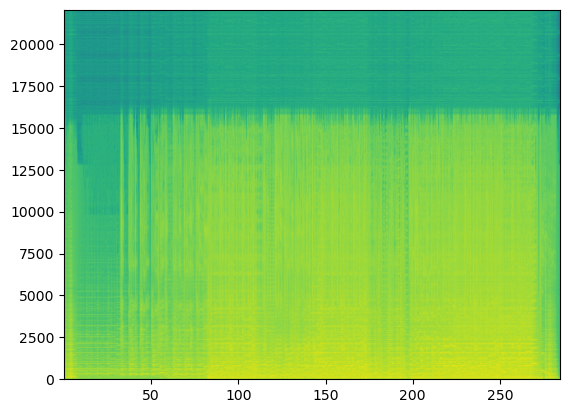

In [79]:
adb = AudioDatabase()

adb.add_song("adele_skyfall", "adele_skyfall.mp3")
adb.add_song("sza_saturn", "sza_saturn.mp3")
adb.add_song("theweekend_blindinglights","theweekend_blindinglights.mp3")
adb.add_song("kane_awholenewworld.m4a")

adb.query_database()